# Size Community Distribution

En nuestra etapa anterior, analizamos las métricas del grafo para comprobar \
si los grafos generados tienen propiedades de red compleja.

Una de las métricas utilizadas fue la modularidad. La métrica compara las aristas \
intra-comunidad e inter-comunidad con un modelo nulo esperado.

En este primer análisis se busca analizar la distribución del tamaño de comunidades \
con el algortimo de Louvain. De acuerdo a la literatura, muchos estudops reportan \
una distribución de cola larga. Lo anterior implica que una gran cantidad de \
comunidades pequeñas coexisten con comunidades grands.

Se tiene la hipótesis que una distribución de tamaño de comunidades que carece \
de una propiedad de cola larga carece de una estructura única o detectable de \
comunidades.

En este experimento, se análizan los cuatro datasets de control de acceso. \
Para arrojar más información a los resultados, se análiza también en los datasets \
"grandes".

In [2]:
### importar bibliotecas

import igraph as ig
import matplotlib.pyplot as plt
import numpy as np

# For degree visualization
from math import log2, ceil
from collections import Counter


In [3]:
### Auxiliar functions

def calculate_log_binning(degree_distribution, n_bins):
    """Compute the log-binning y-values in the degree distribution.

    Divides the degree distribution in `n_bins` segments.

    Parameters
    ----------
    degree_distribution: list
        Network degree distribution.
    n_bins:
        Number of bins to assign.

    Returns
    -------
    (list, list)
        The (x_values, y_values_log_bin_list) tuple.
    """
    current_sum = 0
    previous_k = 0
    y_values_log_bin_list = []
    x_values = []

    for i in range(1, n_bins):
        x_values.append(previous_k)
        current_k = 2 ** (i)
        current_sum = current_sum + current_k
        temp_y_value = sum(degree_distribution[previous_k:current_k])
        temp_y_value = temp_y_value / (current_k-previous_k)
        y_values_log_bin_list.append(temp_y_value)
        previous_k = current_k

        if current_sum > len(degree_distribution):
            x_values.append(previous_k)
            temp_y_value = sum(degree_distribution[previous_k:len(degree_distribution)])
            temp_y_value = temp_y_value / (len(degree_distribution)-previous_k)
            y_values_log_bin_list.append(temp_y_value)            
            break

    return x_values, y_values_log_bin_list

def get_path_topbot(tpe):
    """Return the paht of a type of nodes."""
    
    if tpe:
        return "01-Top"
    else:
        return "02-Bot"

def get_path_dataset(ds):
    """Return the path of a dataset ds."""

    if ds == "AMZ":
        return "01-AMZ"
    elif ds == "HC":
        return "02-HC"
    elif ds == "PM":
        return "03-PM"
    elif ds == "UN":
        return "04-UN"
    else:
        return None

In [32]:
DATASET = "AMZ" # AMZ, HC, PM, UN
NODE_TYPE = True

PATH_DATASET = get_path_dataset(DATASET)
PATH_NODETYPE = get_path_topbot(NODE_TYPE)

#FILE_GRAPH = "../00-Data/" + PATH_DATASET + "/02-Graphs/" + PATH_NODETYPE + "/"

FILE_GRAPH = "../00-Data/01-AMZ/02-Graphs/01-Top/AMZ_top_resall_noise_alpha1.graphml"

In [33]:
### Read a graph

g = ig.read(FILE_GRAPH)
print(g.summary(), "\n")

print("Graph info:")
print("\t|V| =", g.vcount())
print("\t|E| =", g.ecount())
print("\t d  =", g.density())

IGRAPH U-WT 7518 72277 -- 
+ attr: frequency (v), id (v), type (v), weight (e) 

Graph info:
	|V| = 7518
	|E| = 72277
	 d  = 0.002557898116048246


In [35]:
### Compute Louvain Algorithm

comms = g.community_multilevel(weights=g.es["weight"])
print(comms.summary(), "\n")

# ¿Cuántas comunidades tienen size de 1?
temp_var = comms.sizes().count(1)
print(
    f"Núm de comunidades con 1 elemento: {temp_var} "
    f"({temp_var*100/len(comms.sizes()):.2f}%)"
)

comms_with_one = [i for i in comms.subgraphs() if len(i.vs) == 1]

# Realizando un análisis de gráficar unicamente las comunidades con mas de 1.
sizes_without_one = [i for i in comms.sizes() if i > 1]
sizes_without_one = sorted(sizes_without_one, reverse=True)
print(
    f"Num de comunidades > 1: {len(sizes_without_one)}"
    f"({len(sizes_without_one)*100/len(comms.sizes()):.2f}%)"
)

# Obtener datos de la distrubución en forma de histograma
sizedistri_counts, sizedistri_bins = np.histogram(sizes_without_one,
                                                  bins=len(sizes_without_one))
print("Counts:", sizedistri_counts[:10])
print("Bins:", sizedistri_bins[:10])

Clustering with 7518 elements and 5608 clusters 

Núm de comunidades con 1 elemento: 5323 (94.92%)
Num de comunidades > 1: 285(5.08%)
Counts: [241  13   6   3   3   4   0   1   0   2]
Bins: [ 2.          4.10526316  6.21052632  8.31578947 10.42105263 12.52631579
 14.63157895 16.73684211 18.84210526 20.94736842]


In [36]:
### Degree analysis

# Obtener la distribución de grados en forma de histograma
degree_counts = sorted(sizes_without_one, reverse=True)
# Obtener datos de la distrubución en forma de histograma
sizedistri_counts, degree_bins = np.histogram(sizes_without_one,
                                                  bins=len(sizes_without_one))

<Figure size 640x480 with 0 Axes>

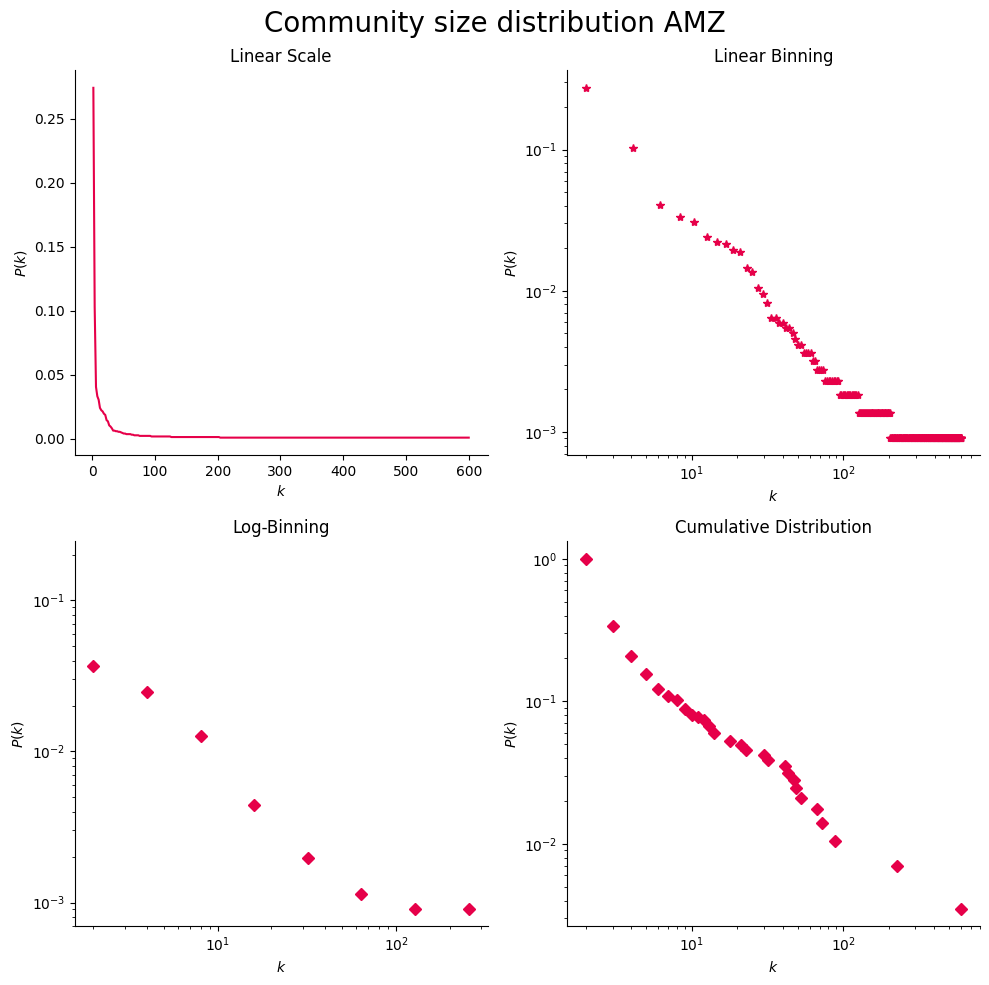

In [37]:
max_size = max(degree_counts)
size_graph_data = np.array(degree_counts) / sum(degree_counts)

plt.clf()
fig, axs = plt.subplots(2, 2, figsize=(10,10))

# LINEAR SCALE
axs[0, 0].set_title('Linear Scale')
#axs[0,0 ].bar(degree_bins[:-1], size_graph_data, color='#e60049',
#              width=np.diff(degree_bins), align='edge') #Replicates plt.hist
axs[0, 0].plot(degree_bins[:-1], size_graph_data, color='#e60049')
axs[0, 0].set(ylabel='$P(k)$', xlabel='$k$')
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)

# LINEAR BINNING
axs[0, 1].set_title('Linear Binning')
axs[0, 1].plot(degree_bins[:-1], size_graph_data, color="#e60049", marker='*', ls='None')
axs[0, 1].loglog()
axs[0, 1].set(ylabel='$P(k)$', xlabel='$k$')
axs[0, 1].spines['top'].set_visible(False)
axs[0, 1].spines['right'].set_visible(False)

# LOG-BINNING
axs[1, 0].set_title('Log-Binning')
n_log_bin = ceil(log2(max_size))
x_values, y_values = calculate_log_binning(size_graph_data, n_log_bin)
axs[1, 0].plot(x_values, y_values, color='#e60049', marker="D", ls='None')
axs[1, 0].loglog()
axs[1, 0].set(ylabel='$P(k)$', xlabel='$k$')
axs[1, 0].spines['top'].set_visible(False)
axs[1, 0].spines['right'].set_visible(False)

# COMULATIVE
axs[1, 1].set_title("Cumulative Distribution")
degreeCount = Counter(degree_counts)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(np.array(cnt)/len(degree_counts))
axs[1, 1].loglog(deg, cs, color='#e60049', marker="D", ls='None')
axs[1, 1].set(ylabel='$P(k)$', xlabel='$k$')
axs[1, 1].spines['top'].set_visible(False)
axs[1, 1].spines['right'].set_visible(False)

fig.suptitle("Community size distribution "+DATASET, fontsize=20)
fig.tight_layout()
plt.show()

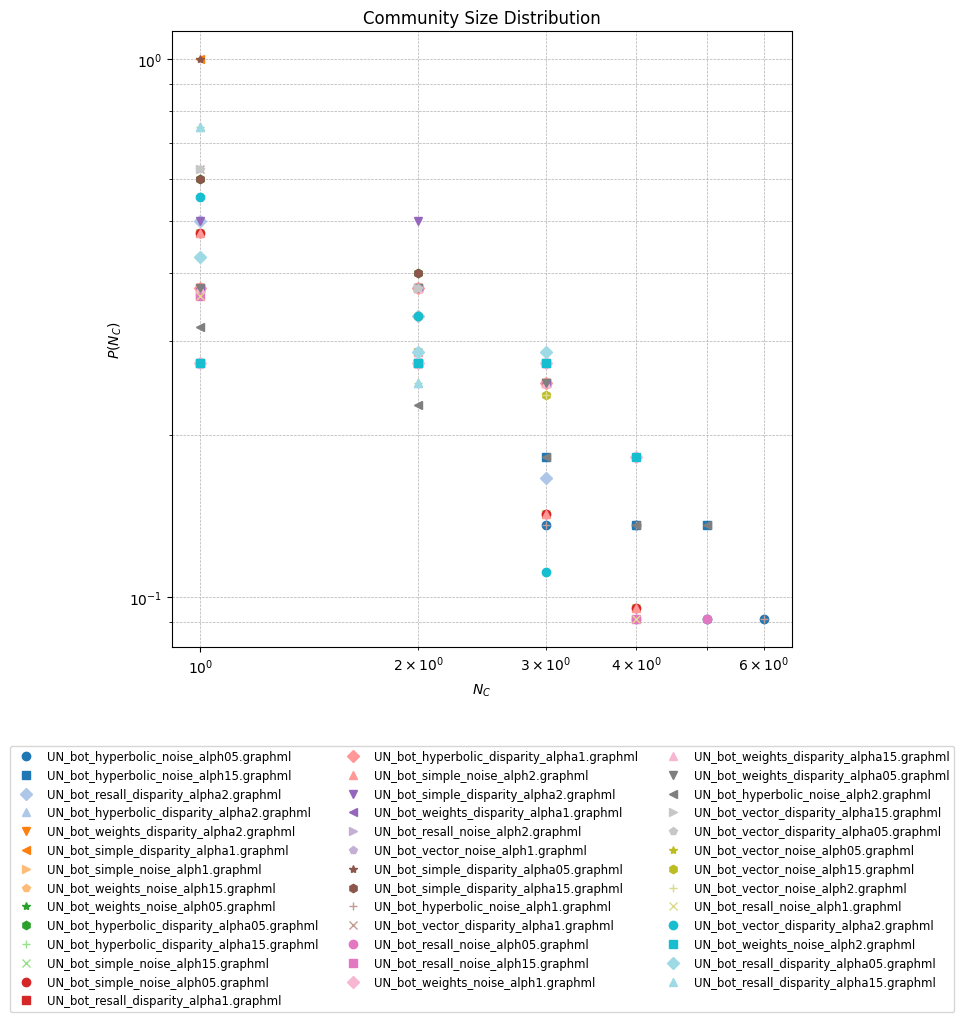

In [156]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from math import log2, ceil


DATASET = "UN" # AMZ, HC, PM, UN
NODE_TYPE = False

PATH_DATASET = get_path_dataset(DATASET)
PATH_NODETYPE = get_path_topbot(NODE_TYPE)

FILE_GRAPH = "../00-Data/" + PATH_DATASET + "/02-Graphs/" + PATH_NODETYPE + "/"

# Función auxiliar para calcular la distribución log-bin

def calculate_log_binning(degree_distribution, n_bins):
    x_values, y_values_log_bin_list = [], []
    current_sum, previous_k = 0, 0
    for i in range(1, n_bins):
        x_values.append(previous_k)
        current_k = 2 ** i
        current_sum += current_k
        temp_y_value = sum(degree_distribution[previous_k:current_k]) / (current_k - previous_k)
        y_values_log_bin_list.append(temp_y_value)
        previous_k = current_k
        if current_sum > len(degree_distribution):
            x_values.append(previous_k)
            temp_y_value = sum(degree_distribution[previous_k:]) / (len(degree_distribution) - previous_k)
            y_values_log_bin_list.append(temp_y_value)
            break
    return x_values, y_values_log_bin_list

# Directorio donde están los archivos .graphml
directory = FILE_GRAPH
graph_files = [f for f in os.listdir(directory) if f.endswith(".graphml")]

# Definir colores y marcadores para diferenciación
colors = plt.get_cmap("tab20", len(graph_files))
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', '+', 'x']

# Leer y graficar cada grafo
plt.figure(figsize=(8, 8))
for idx, file in enumerate(graph_files):
    g = ig.Graph.Read_GraphML(os.path.join(directory, file))
    
    # Obtener distribución de tamaños de comunidad
    comms = g.community_multilevel(weights=g.es["weight"])
    sizes_without_one = sorted([s for s in comms.sizes() if s > 1], reverse=True)
    
    if not sizes_without_one:
        continue  # Evitar errores con grafos sin comunidades
    
    size_graph_data = np.array(sizes_without_one) / sum(sizes_without_one)
    degree_bins = np.arange(1, len(sizes_without_one) + 1)
    
    plt.plot(degree_bins, size_graph_data, 
             label=f"{file}", 
             color=colors(idx), 
             marker=markers[idx % len(markers)], linestyle='None')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N_C$')
plt.ylabel('$P(N_C)$')
plt.title('Community Size Distribution')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize='small')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


In [46]:
freq_suma = []
for i in comms_with_one:
    id_nodo = i.vs()["frequency"] # Id del nodo
    freq_suma.append(id_nodo)
len(freq_suma), max(freq_suma)

(5323, [408.0])

<Figure size 640x480 with 0 Axes>

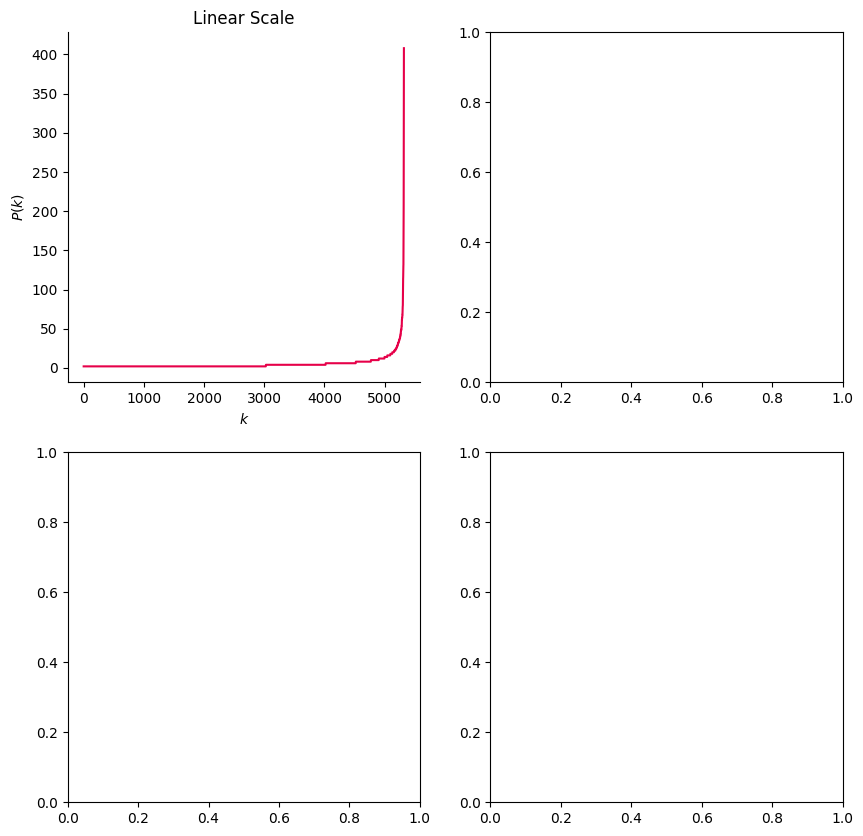

In [41]:
max_size = max(degree_counts)
size_graph_data = np.array(degree_counts) / sum(degree_counts)

plt.clf()
fig, axs = plt.subplots(2, 2, figsize=(10,10))

# LINEAR SCALE
axs[0, 0].set_title('Linear Scale')
axs[0, 0].plot(sorted(freq_suma), color='#e60049')
axs[0, 0].set(ylabel='$P(k)$', xlabel='$k$')
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)

In [42]:

# Arreglo de enteros de ejemplo
data = freq_suma

# Media
mean = np.mean(data)
print(f"Media: {mean}")

# Mediana
median = np.median(data)
print(f"Mediana: {median}")

# Moda
#mode = stats.mode(data)
#print(f"Moda: {mode.mode[0]} (aparece {mode.count[0]} veces)")

# Desviación estándar
std_dev = np.std(data)
print(f"Desviación estándar: {std_dev}")

# Varianza
variance = np.var(data)
print(f"Varianza: {variance}")

# Mínimo
min_value = np.min(data)
print(f"Mínimo: {min_value}")

# Máximo
max_value = np.max(data)
print(f"Máximo: {max_value}")

# Rango (diferencia entre el máximo y el mínimo)
range_value = np.ptp(data)  # ptp = "peak to peak"
print(f"Rango: {range_value}")

# Suma de todos los elementos
sum_value = np.sum(data)
print(f"Suma: {sum_value}")

# Cuartiles (25%, 50%, 75%)
quartiles = np.percentile(data, [25, 50, 75])
print(f"Cuartiles (25%, 50%, 75%): {quartiles}")

# Rango intercuartílico (IQR)
iqr = stats.iqr(data)
print(f"Rango intercuartílico (IQR): {iqr}")

Media: 5.374412925042269
Mediana: 2.0
Desviación estándar: 12.823582175955409
Varianza: 164.44425982348125
Mínimo: 2.0
Máximo: 408.0
Rango: 406.0
Suma: 28608.0
Cuartiles (25%, 50%, 75%): [2. 2. 4.]


NameError: name 'stats' is not defined

In [144]:
typenodes = bg.vs.select(type_eq=1)
print(len(typenodes))
other_data = typenodes["frequency"]

9298


In [163]:

# Arreglo de enteros de ejemplo
data = todo

# Media
mean = np.mean(data)
print(f"Media: {mean}")

# Mediana
median = np.median(data)
print(f"Mediana: {median}")

# Moda
#mode = stats.mode(data)
#print(f"Moda: {mode.mode[0]} (aparece {mode.count[0]} veces)")

# Desviación estándar
std_dev = np.std(data)
print(f"Desviación estándar: {std_dev}")

# Varianza
variance = np.var(data)
print(f"Varianza: {variance}")

# Mínimo
min_value = np.min(data)
print(f"Mínimo: {min_value}")

# Máximo
max_value = np.max(data)
print(f"Máximo: {max_value}")

# Rango (diferencia entre el máximo y el mínimo)
range_value = np.ptp(data)  # ptp = "peak to peak"
print(f"Rango: {range_value}")

# Suma de todos los elementos
sum_value = np.sum(data)
print(f"Suma: {sum_value}")

# Cuartiles (25%, 50%, 75%)
quartiles = np.percentile(data, [25, 50, 75])
print(f"Cuartiles (25%, 50%, 75%): {quartiles}")

# Rango intercuartílico (IQR)
iqr = stats.iqr(data)
print(f"Rango intercuartílico (IQR): {iqr}")

Media: 7.139666864075795
Mediana: 4.0
Desviación estándar: 20.780051221736418
Varianza: 431.81052877798913
Mínimo: 2.0
Máximo: 936.0
Rango: 934.0
Suma: 50377.48939291881
Cuartiles (25%, 50%, 75%): [2. 4. 6.]
Rango intercuartílico (IQR): 4.0


In [49]:
comms_rest = [i for i in comms.subgraphs() if len(i.vs) > 1]
freq_Rest = []
max_value = 400
for i in comms_rest:
    for node in i.vs():
        id_nodo = node["frequency"] # Id del nodo
        if id_nodo > max_value:
            print(id_nodo)
            max_value = id_nodo
        freq_Rest.append(id_nodo)
len(freq_Rest)

472.0
808.0
1678.0


2195

In [51]:
# Arreglo de enteros de ejemplo
data = freq_Rest

# Media
mean = np.mean(data)
print(f"Media: {mean}")

# Mediana
median = np.median(data)
print(f"Mediana: {median}")

# Moda
#mode = stats.mode(data)
#print(f"Moda: {mode.mode[0]} (aparece {mode.count[0]} veces)")

# Desviación estándar
std_dev = np.std(data)
print(f"Desviación estándar: {std_dev}")

# Varianza
variance = np.var(data)
print(f"Varianza: {variance}")

# Mínimo
min_value = np.min(data)
print(f"Mínimo: {min_value}")

# Máximo
max_value = np.max(data)
print(f"Máximo: {max_value}")

# Rango (diferencia entre el máximo y el mínimo)
range_value = np.ptp(data)  # ptp = "peak to peak"
print(f"Rango: {range_value}")

# Suma de todos los elementos
sum_value = np.sum(data)
print(f"Suma: {sum_value}")

# Cuartiles (25%, 50%, 75%)
quartiles = np.percentile(data, [25, 50, 75])
print(f"Cuartiles (25%, 50%, 75%): {quartiles}")


Media: 16.8246013667426
Mediana: 4.0
Desviación estándar: 65.14737269652726
Varianza: 4244.180169260225
Mínimo: 2.0
Máximo: 1678.0
Rango: 1676.0
Suma: 36930.0
Cuartiles (25%, 50%, 75%): [ 2.  4. 10.]


<Figure size 640x480 with 0 Axes>

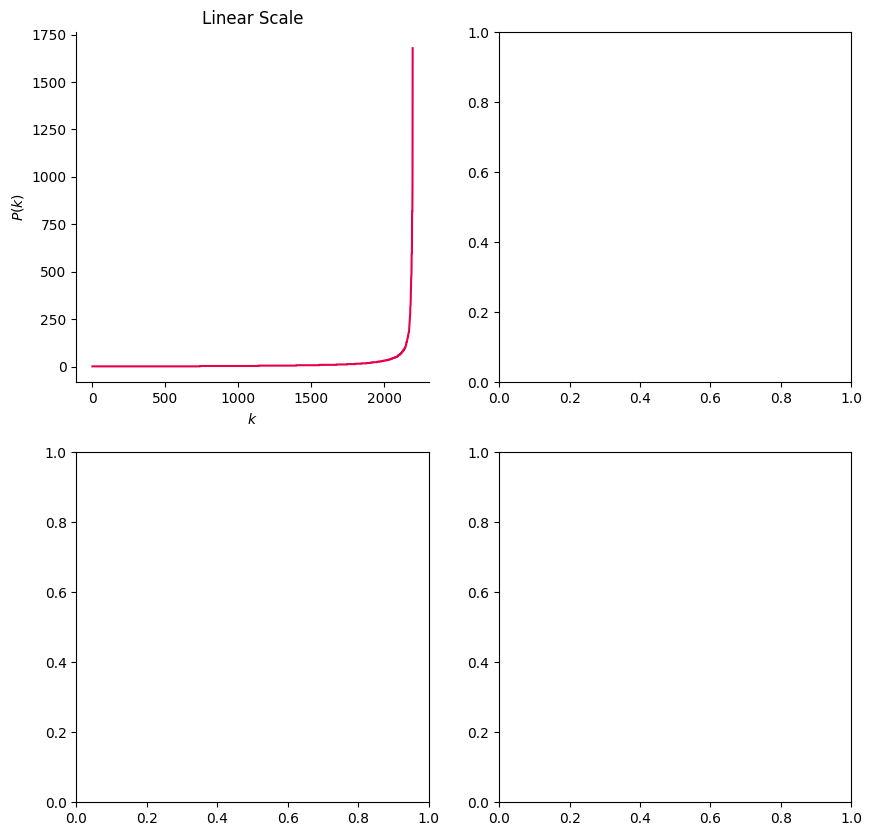

In [52]:
plt.clf()
fig, axs = plt.subplots(2, 2, figsize=(10,10))

# LINEAR SCALE
axs[0, 0].set_title('Linear Scale')
axs[0, 0].plot(sorted(freq_Rest), color='#e60049')
axs[0, 0].set(ylabel='$P(k)$', xlabel='$k$')
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)

In [161]:
todo = freq_suma+freq_Rest
len(todo)

7056